# 数据清洗与准备

在数据分析和建模的过程中，相当多的时间要用在数据准备上：加载、清理、转换以及重塑。这些工作会占到分析师时间的80%或更多。有时，存储在文件和数据库中的数据的格式不适合某个特定的任务。许多研究者都选择使用通用编程语言（如Python、Perl、R或Java）或UNIX文本处理工具（如sed或awk）对数据格式进行专门处理。幸运的是，pandas和内置的Python标准库提供了一组高级的、灵活的、快速的工具，可以让你轻松地将数据规整为想要的格式。

如果你发现了一种本书或pandas库中没有的数据操作方式，请在邮件列表或GitHub网站上提出。实际上，pandas的许多设计和实现都是由真实应用的需求所驱动的。

在本章中，我会讨论**处理缺失数据**、**重复数据**、**字符串操作**和**其它分析数据转换**的工具。下一章，我会关注于用多种方法合并、重塑数据集。

## 处理缺失值

缺失数据会在很多数据分析应用中出现。pandas的目标之一就是尽可能无痛地处理缺失值。例如，pandas对象的所有描述性统计信息默认情况下是**排除缺失值的。**

pandas对象中表现缺失值的方式并不完美，但是它对大部分用户来说是有用的。对于数值型数据，pandas使用浮点值NaN（Not a Number 来表示缺失值）。我们称NaN为容易检测到的标识值：

In [2]:
import pandas as pd
import numpy as np

In [3]:
string_data = pd.Series(['aardvark', 'artichoke', np.nan, 'avocado'])
string_data

0     aardvark
1    artichoke
2          NaN
3      avocado
dtype: object

In [4]:
string_data.isnull()

0    False
1    False
2     True
3    False
dtype: bool

在pandas中，我们采用了R语言中的编程惯例，将缺失值成为NA，意思是not available（不可用）。在统计学应用中，NA数据可以是不存在的数据或者是存在但不可观察的数据（例如在数据收集过程中出现了问题）。当清洗数据用于分析时，对缺失数据本身进行分析以确定收集数据问题或数据丢失导致的数据偏差通常很重要。

Python内建的None值在对象数组中也被当做NA处理：

In [5]:
string_data[0] = None
string_data.isnull()

0     True
1    False
2     True
3    False
dtype: bool

pandas项目持续改善处理缺失值的内部细节，但是用户API函数，比如pandas.isnull，抽象掉了很多令人厌烦的细节。下表是处理缺失值的相关函数列表：

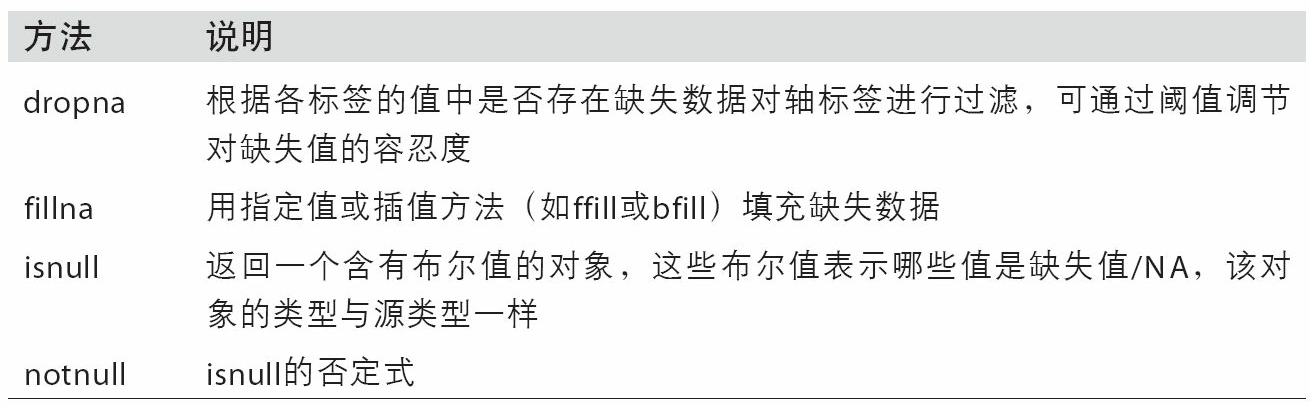

### 过滤缺失值

过滤缺失值的方法有很多，比如可以使用pandas.isnull和布尔值索引手动地过滤缺失值，但还可以使用dropna过滤缺失值。在Series上使用dropna，它会返回Series中所有的非空数据及其索引值：

In [6]:
from numpy import nan as NA

In [7]:
data = pd.Series([1, NA, 3.5, NA, 7])
data

0    1.0
1    NaN
2    3.5
3    NaN
4    7.0
dtype: float64

In [8]:
data.dropna()

0    1.0
2    3.5
4    7.0
dtype: float64

上面的例子与下面的代码是等价的：

In [9]:
data[data.notnull()]

0    1.0
2    3.5
4    7.0
dtype: float64

当处理DataFrame对象时，事情会稍微更复杂一点。你可能想要删除全部为NA或包含有NA的行或列。dropna默认情况下会删除包含缺失值的行：

In [10]:
data = pd.DataFrame([[1., 6.5, 3.],[1., NA, NA],[NA, NA, NA],[NA, 6.5, 3.]])
data

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


In [11]:
cleaned = data.dropna()
cleaned

,0,1,2
0,1.0,6.5,3.0


传入how='all'时，将删除所有值均为NA的行：

In [12]:
data.dropna(how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
3,NaN,6.5,3.0


如果要用同样的方式取删除列，传入参数axis=1：

In [13]:
data[4] = NA
data

,0,1,2,4
0,1.0,6.5,3.0,NaN
1,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,6.5,3.0,NaN


In [14]:
data.dropna(axis=1,how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


过滤DataFrame的行的相关方法往往涉及时间序列数据。假设只想保留包含一定数量的观测值的行。可以使用thresh参数来表示：

In [15]:
df = pd.DataFrame(np.random.randn(7, 3))
df.iloc[:4,1] = NA
df.iloc[:2,2] = NA
df

,0,1,2
0,-0.634553,NaN,NaN
1,0.036164,NaN,NaN
2,0.621361,NaN,0.042978
3,0.526419,NaN,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


In [16]:
df.dropna()

,0,1,2
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


In [17]:
df.dropna(thresh=2)

,0,1,2
2,0.621361,NaN,0.042978
3,0.526419,NaN,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


>thresh表示每行需要几个非缺失值

In [18]:
df.dropna(subset=[2])

,0,1,2
2,0.621361,NaN,0.042978
3,0.526419,NaN,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


>subset指定在哪个变量上去除缺失值

### 补全缺失值

有时可能需要以多种方式补全“漏洞”，而不是过滤缺失值（也可能丢弃其他数据）。大多数情况下，主要使用fillna方法来补全缺失值。调用fillna时，可以使用一个常数来替代缺失值：

In [19]:
df.fillna(0)

,0,1,2
0,-0.634553,0.000000,0.000000
1,0.036164,0.000000,0.000000
2,0.621361,0.000000,0.042978
3,0.526419,0.000000,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


在调用fillna时使用字典，可以为不同列设定不同的填充值：

In [20]:
df.fillna({1: 0.5,2: 0})

,0,1,2
0,-0.634553,0.500000,0.000000
1,0.036164,0.500000,0.000000
2,0.621361,0.500000,0.042978
3,0.526419,0.500000,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


fillna返回的是一个新的对象，但你也可以对现有对象进行修改：

In [21]:
_ = df.fillna(0, inplace=True)

In [22]:
df

,0,1,2
0,-0.634553,0.000000,0.000000
1,0.036164,0.000000,0.000000
2,0.621361,0.000000,0.042978
3,0.526419,0.000000,0.937046
4,0.216800,0.152751,-0.933304
5,-0.186573,-0.530839,0.917431
6,-0.072859,-0.080749,-1.523191


用于重建索引的相同的插值方法也可以用于fillna：

In [23]:
df = pd.DataFrame(np.random.randn(6, 3))
df.iloc[2:, 1] = NA
df.iloc[4:, 2] = NA
df

,0,1,2
0,0.066676,-0.826124,-0.180906
1,-0.340649,0.048760,-0.277619
2,-0.885601,NaN,0.373469
3,0.149282,NaN,0.951542
4,0.276706,NaN,NaN
5,-0.784041,NaN,NaN


In [24]:
df.fillna(method='ffill')

,0,1,2
0,0.066676,-0.826124,-0.180906
1,-0.340649,0.048760,-0.277619
2,-0.885601,0.048760,0.373469
3,0.149282,0.048760,0.951542
4,0.276706,0.048760,0.951542
5,-0.784041,0.048760,0.951542


In [25]:
df.fillna(method='ffill', limit=2)

,0,1,2
0,0.066676,-0.826124,-0.180906
1,-0.340649,0.048760,-0.277619
2,-0.885601,0.048760,0.373469
3,0.149282,0.048760,0.951542
4,0.276706,NaN,0.951542
5,-0.784041,NaN,0.951542


>limit参数是约束每列中最多填充几个缺失值

使用fillna()你可以完成很多带有一点创造性的工作。例如，你可以将Series的平均值或中位数用于填充缺失值：

In [26]:
data = pd.Series([1., NA, 3.5, NA, 7])
data

0    1.0
1    NaN
2    3.5
3    NaN
4    7.0
dtype: float64

In [27]:
data.fillna(data.mean())

0    1.000000
1    3.833333
2    3.500000
3    3.833333
4    7.000000
dtype: float64

fillna函数的参数

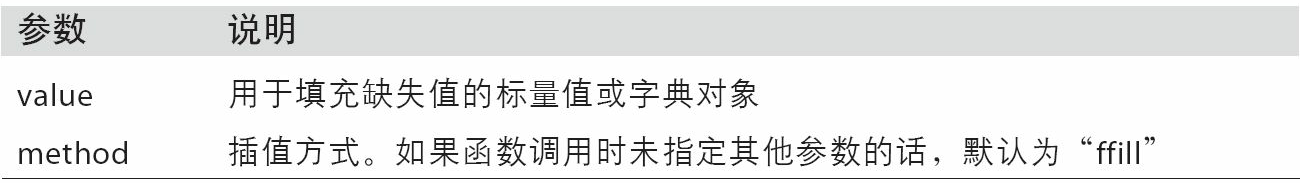

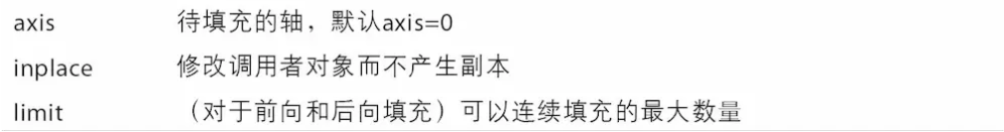

## 数据转换

目前为止，我们主要讲解了数据的重新排列。过滤、清洗以及其他转换是另一类重要的操作。

### 删除重复值

由于各种原因，DataFrame中会出现重复行。请看如下例子：

In [28]:
data = pd.DataFrame({'k1': ['one','two'] * 3 + ['two'],'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4
6,two,4


DataFrame的duplicated方法返回的是一个布尔值Series，这个Series检查的是行于行之间时是否存在重复（与之前出现过的行相同）情况：

In [29]:
data.duplicated()
#df.duplicated(subset=None, keep='first')

0    False
1    False
2    False
3    False
4    False
5    False
6     True
dtype: bool

drop_duplicates返回的是DataFrame，这个返回的DataFrame的数据内容是对应的duplicated返回数组的False部分：

In [30]:
data.drop_duplicates()
#data.drop_duplicates(subset=None, keep='first', inplace=False)

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4


这些方法默认都是对列进行操作。可以指定数据的任何自己来检验是否有重复。假设有一个额外的列，并想基于'k1'列去除重复值：

In [31]:
data['v1'] = range(7)
data

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
5,two,4,5
6,two,4,6


In [32]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
1,two,1,1


duplicated和drop_duplicates默认都是保留第一个观测到的值。传入参数keep='last'则保留最后一个：

In [33]:
data.drop_duplicates(['k1','k2'], keep='last')

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
6,two,4,6


### 使用函数或映射进行数据转换

对于许多数据集，你可能希望基于数组、Series和DataFrame的列中的值进行一些转换。考虑下面这些收集到的关于肉类的假设数据：

In [34]:
data = pd.DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
                              'corned beef', 'Bacon', 'pastrami', 'honey ham', 'nova lox'],
                    'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


假设想要添加一列用于表明每种食物的动物肉类型。下面写一个食物和肉类的映射：

In [35]:
meat_to_animal = {'bacon': 'pig', 'pulled pork': 'pig', 'pastrami': 'cow', 'corned beef': 'cow',
                  'honey ham': 'pig', 'nova lox': 'salmon'}
meat_to_animal

{'bacon': 'pig',
 'pulled pork': 'pig',
 'pastrami': 'cow',
 'corned beef': 'cow',
 'honey ham': 'pig',
 'nova lox': 'salmon'}

Series的map方法接收一个函数或包含一个映射关系的字典型对象，但是这里我们有一个小的问题在于一些肉类大写了，而另一部分肉类没有。因此，我们需要使用Series的str.lower方法将每一个字都转换为小写：

In [36]:
lowercased = data['food'].str.lower()
lowercased

0          bacon
1    pulled pork
2          bacon
3       pastrami
4    corned beef
5          bacon
6       pastrami
7      honey ham
8       nova lox
Name: food, dtype: object

In [37]:
data['animal'] = lowercased.map(meat_to_animal)
#map(self,func or *iterables)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


也可以传入一个能够完成所有工作的函数：

In [38]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

> map是一种可以便捷执行按元素转换及其他清洗相关操作的方法。

### 替代值

使用fillna填充缺失值是通用替换的特殊案例。前面已经提到，map可以用来修改一个对象中的子集的值，但是replace提供了更为简单灵活的实现。看下面的例子：

In [39]:
data = pd.Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

-999可能是缺失值的标识。如果要使用NA来代替这些值，可以使用replace方法生成新的Series（除非传入了inplace=True）：

In [40]:
data.replace(-999, np.nan)
#data.replace(
    ['to_replace=None', 'value=None', 'inplace=False', 'limit=None', 'regex=False', "method='pad'"])

IndentationError: unexpected indent (<ipython-input-40-96a2f6951d41>, line 3)

传入一个列表和替代值可以实现一次替换多个值：

In [41]:
data.replace([-999,-1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

传入一个被替代值的列表和一个替代值的列表可以实现一次分别替换不同的值：

In [42]:
data.replace([-999,-1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

+ 参数也可以通过**字典传递：**

In [43]:
data.replace({-999:np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

> data.replace方法与data.str.replace不同，后者做的是字符串的元素级替换。我们会在后面学习Series的字符串方法。

### 重命名轴索引

和Series中的值一样，可以通过函数或某种形式的映射对轴标签进行类似的转换，生成新的且带有不同标签的对象。也可以在不生成新的数据结构的情况下修改轴。下面是简单的示例：

In [44]:
data = pd.DataFrame(np.arange(12).reshape((3, 4)),
                   index=['Ohio','Colorado', 'New York'],
                   columns=['one','two','three','four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


重命名方法一：与Series类似，轴索引也有一个map方法：

In [45]:
transform = lambda x: x[:4].upper()#只取前4个字符
data.index.map(transform)

Index(['OHIO', 'COLO', 'NEW '], dtype='object')

可以将转换的标签赋值给index，修改DataFrame：

In [46]:
data.index = data.index.map(transform)
data

,one,two,three,four
OHIO,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


重命名方法二：如果想要创建数据集的转换版（而不是修改原始数据），比较实用的方法是rename：

In [47]:
data.rename(index=str.title, columns=str.upper)
#data.rename(['mapper=None', 'index=None', 'columns=None', 'axis=None', 'copy=True', 'inplace=False', 'level=None'],)
#mapper映射器

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colo,4,5,6,7
New,8,9,10,11


In [48]:
data

,one,two,three,four
OHIO,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


rename可以结合字典型对象使用，实现对部分轴标签的更新：

In [49]:
data.rename(index={'OHIO':'INDIANA'},columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


rename可以实现复制DataFrame并对其索引和列标签进行赋值。如果希望就地修改某个数据集，传入inplace=True即可：

In [50]:
data.rename(index={'OHIO': 'INDIANA'}, inplace=True)
data

,one,two,three,four
INDIANA,0,1,2,3
COLO,4,5,6,7
NEW,8,9,10,11


### 离散化和分箱

连续值经常需要离散化，或者分离成“箱子”进行分析。假设你有一组人员的数据，你希望将他们划分为不同的年龄组：

In [51]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

接下来将这些数据划分为“18~25”、“26~35”、“35~60”以及“60以上”等若干组。要实现该功能，你需要使用pandas的cut函数：

In [52]:
bins = [18, 25, 35, 60, 100]

In [53]:
cats = pd.cut(ages,bins)
#pd.cut(['x', 'bins', 'right=True', 'labels=None', 'retbins=False', 'precision=3', 'include_lowest=False', "duplicates='raise'"])
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

pandas返回的对象是一个特殊的Categorical对象。返回结果显示了由pandas.cut计算出的箱。可以将它当作一个表示箱名的字符串数组；在它内部包含一个cate（类别）数组，并指定了不同类别名称以及codes属性中的ages（年龄）数据标签：

In [54]:
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [55]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
              closed='right',
              dtype='interval[int64]')

In [56]:
pd.value_counts(cats)#计算非空值的计数直方图

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

请注意，pd.value_counts(cats)是对pandas.cut的结果中的箱的数量的计数。

跟“区间”的数学符号一样，圆括号表示开放的，而方括号则表示封闭的（包括边）。可以通过right=False改变哪一边是封闭的：

In [57]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, interval[int64]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

可以通过向labels选项传递一个列表或数组来自定义箱名：

In [58]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

如果传递给cut箱的个数来代替显式的箱边，pandas将根据数据中的最小值和最大值计算出等长的箱。下面是服从均匀分布的数据被切成四份的情况：

In [59]:
data = np.random.randn(20)
data

array([-0.04092845,  0.69976588, -0.42035422, -0.94483104, -0.47500363,
       -0.60661916, -2.78136173, -0.59296457, -0.83815952, -0.44522143,
       -1.05847635, -0.24835555,  1.36434331,  0.39127108,  1.26678863,
        1.25605507, -1.93387117,  0.32013925,  0.46086973, -0.50278536])

In [60]:
pd.cut(data,4,precision=2)

[(-0.71, 0.33], (0.33, 1.36], (-0.71, 0.33], (-1.74, -0.71], (-0.71, 0.33], ..., (0.33, 1.36], (-2.79, -1.74], (-0.71, 0.33], (0.33, 1.36], (-0.71, 0.33]]
Length: 20
Categories (4, interval[float64]): [(-2.79, -1.74] < (-1.74, -0.71] < (-0.71, 0.33] < (0.33, 1.36]]

>precision=2的选项将十进制精度限制在两位

qcut是一个与分箱密切相关的函数，它基于样本分位数进行分箱。取决于样本数据的分布，cut通常不会使每个箱具有相同数据量的数据点。由于qcut使用样本的分位数，因此通过qcut可以获得等长的箱，即每个箱具有相同数据量的数据点：

In [61]:
data = np.random.randn(1000)#正态分布
data[:20]

array([ 1.01745341,  0.56055854,  0.53131578,  1.54356152,  1.60070868,
       -1.30780501, -2.24467378, -0.33118735,  2.45197529, -1.04441958,
        0.00420977, -0.89784855,  0.39084781,  0.99366336, -0.95169279,
       -0.52895516, -1.37821865, -0.52900492,  0.17995842, -0.67542358])

In [62]:
cats = pd.qcut(data,4) #=切成四份
cats

[(0.614, 2.944], (-0.0225, 0.614], (-0.0225, 0.614], (0.614, 2.944], (0.614, 2.944], ..., (-0.0225, 0.614], (-0.0225, 0.614], (-0.0225, 0.614], (-0.0225, 0.614], (0.614, 2.944]]
Length: 1000
Categories (4, interval[float64]): [(-3.584, -0.763] < (-0.763, -0.0225] < (-0.0225, 0.614] < (0.614, 2.944]]

In [63]:
pd.value_counts(cats)

(0.614, 2.944]       250
(-0.0225, 0.614]     250
(-0.763, -0.0225]    250
(-3.584, -0.763]     250
dtype: int64

与cut类似，可以传入自定义的分位数（0和1之间的数据，包括边）：

In [64]:
cats_1 = pd.qcut(data,[0,0.1,0.5,0.9,1])
cats_1

[(-0.0225, 1.246], (-0.0225, 1.246], (-0.0225, 1.246], (1.246, 2.944], (1.246, 2.944], ..., (-0.0225, 1.246], (-0.0225, 1.246], (-0.0225, 1.246], (-0.0225, 1.246], (1.246, 2.944]]
Length: 1000
Categories (4, interval[float64]): [(-3.584, -1.377] < (-1.377, -0.0225] < (-0.0225, 1.246] < (1.246, 2.944]]

In [65]:
pd.value_counts(cats_1)

(-0.0225, 1.246]     400
(-1.377, -0.0225]    400
(1.246, 2.944]       100
(-3.584, -1.377]     100
dtype: int64

本章稍后在讲解聚合和分组运算时会再次用到cut和qcut，因为这两个离散化函数对分位和分组分析非常重要。

### 检测和过滤异常值

**过滤或转化异常值在很大程度上是应用数组操作的事情。**考虑一个具有正态分布数据的DataFrame：
+ 通过通用条件来检索异常值

In [66]:
data = pd.DataFrame(np.random.randn(1000,4))
data.head()

,0,1,2,3
0,0.938085,-0.396216,1.596155,-0.919018
1,0.146109,1.145377,-1.358753,1.209243
2,2.428874,0.477333,0.559171,-1.144518
3,0.244605,-0.884959,-0.127202,-0.499265
4,1.077664,-1.478163,-0.215045,0.136634


In [67]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.011780,0.013700,-0.002047,0.028688
std,1.017841,1.009273,0.987792,0.977917
min,-3.026703,-3.068377,-3.094798,-3.129136
25%,-0.623682,-0.640998,-0.660235,-0.642969
50%,0.004853,0.023219,-0.015026,0.017718
75%,0.729562,0.681339,0.667310,0.655247
max,2.874905,2.837361,3.002321,3.625861


假设想找出一列中绝对值大于三的值：

In [68]:
col = data[2]
col[np.abs(col) > 3]

157   -3.073103
193    3.002321
483   -3.084400
929   -3.094798
Name: 2, dtype: float64

如果要选出所有值大于3或小于-3的行，可以对布尔值DataFrame使用any方法：

In [69]:
data[(np.abs(data) > 3).any(axis=1)]

,0,1,2,3
157,-0.888179,0.874463,-3.073103,1.616885
193,0.582020,-1.252252,3.002321,-0.431372
199,-0.621610,0.980593,0.718044,-3.129136
243,0.665733,2.488996,1.241452,3.479610
266,-2.659180,-0.993813,-0.749795,3.625861
483,-0.873514,0.612367,-3.084400,-1.516594
507,0.646898,-3.068377,-0.377631,-2.103250
672,-0.916410,0.475829,-1.829751,3.020642
790,-0.194122,-0.221810,-0.649718,-3.074759
929,-0.788406,1.094368,-3.094798,-1.159146


可以根据标准或条件设置值，下面的代码可以将值限制在区间－3到3以内：

In [70]:
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.011806,0.013768,-0.001797,0.027766
std,1.017761,1.009066,0.987008,0.973520
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.623682,-0.640998,-0.660235,-0.642969
50%,0.004853,0.023219,-0.015026,0.017718
75%,0.729562,0.681339,0.667310,0.655247
max,2.874905,2.837361,3.000000,3.000000


语句np.sign(data).head()根据数据中的值的正负分别生成1和-1的数值：

In [71]:
np.sign(data).head()

,0,1,2,3
0,1.0,-1.0,1.0,-1.0
1,1.0,1.0,-1.0,1.0
2,1.0,1.0,1.0,-1.0
3,1.0,-1.0,-1.0,-1.0
4,1.0,-1.0,-1.0,1.0


### 置换和随机抽样

利用numpy.random.permutation函数可以轻松实现对Series或DataFrame的列的重排列工作（permuting，随机重排序）。通过需要排列的轴的长度调用permutation，可产生一个表示新顺序的整数数组：

In [72]:
df = pd.DataFrame(np.arange(5 * 4).reshape((5, 4)))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [73]:
sampler = np.random.permutation(5)
sampler

array([1, 0, 4, 3, 2])

permutation(x)的用法：

\>>>np.random.permutation(10)

array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6])

\>>> np.random.permutation([1, 4, 9, 12, 15])

array([15,  1,  9,  4, 12])

\>>> arr = np.arange(9).reshape((3, 3))

\>>> np.random.permutation(arr)

array([[6, 7, 8],
       [0, 1, 2],
       [3, 4, 5]])

整数数组可以基于iloc的索引或等价的take函数中：

In [74]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [75]:
df.take(sampler)
#pd.DataFrame.take(['self', 'indices', 'axis=0', 'convert=None', 'is_copy=True', '**kwargs'])

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
4,16,17,18,19
3,12,13,14,15
2,8,9,10,11


如果不想用替换的方式选取随机子集，可以在Series和DataFrame上使用sample方法：

In [76]:
df.sample(n=3)

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
0,0,1,2,3


生成一个带有替代值的样本（允许重复选择），可以传递replace=True到sample：

In [77]:
choices = pd.Series([5, 7, -1, 6, 4])
draws = choices.sample(n=10, replace=True)
draws

0    5
0    5
1    7
2   -1
1    7
0    5
4    4
3    6
2   -1
1    7
dtype: int64

### 计算指标 / 虚拟变量

将分类变量转换为“虚拟”或“指标”矩阵是另一种用于统计建模或机器学习的转换操作。如果DataFrame中的一列由k个不同的值，则可以衍生一个k个列的所有值为1和0的矩阵或DataFrame。pandas有一个**get_dummies**函数可以实现该功能（其实自己动手做一个也不难）。使用之前的一个DataFrame例子：

In [78]:
df = pd.DataFrame({'key': list('bbacab'), 'data1': range(6)})
df

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [79]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


有时候，可能想给指标DataFrame的列加上一个前缀，以便能够跟其他数据进行合并。get_dummies的prefix参数可以实现该功能：
+ prefix参数可以为哑变量值强加一个前缀

In [80]:
dummies = pd.get_dummies(df['key'], prefix='key')
#pd.get_dummies(['data', 'prefix=None', "prefix_sep='_'", 
#               'dummy_na=False', 'columns=None', 'sparse=False', 'drop_first=False', 'dtype=None'])
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [81]:
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


如果DataFrame中的某行同属于多个分类，则事情就会有点复杂。看一下MovieLens的1M数据集，14章会更深入地研究它：

In [105]:
mnames = ['movied_id', 'title', 'genres']
movies = pd.read_table('C:/Users/lenovo/data_of_python/examples/movielens/movies.dat', sep='::', header=None, names=mnames)
movies[:10]

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,movied_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


要为每个genre添加指标变量就需要做一些数据规整操作。首先，我们从数据集中抽取出不同的genre值：

In [106]:
all_genres = []
for x in movies.genres:
    all_genres.extend(x.split('|'))
genres = pd.unique(all_genres)
genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

构建指标DataFrame的方法之一是从一个全零DataFrame开始：

In [107]:
zero_matrix = np.zeros((len(movies), len(genres)))
dummies = pd.DataFrame(zero_matrix, columns=genres)
dummies.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


现在，迭代每一部电影，并将dummies各行的条目设为1。为了实现该功能，我们使用dummies.columns来计算每个类型的列索引：

In [108]:
gen = movies.genres[0]
gen.split('|')

['Animation', "Children's", 'Comedy']

In [109]:
dummies.columns.get_indexer(gen.split('|'))

array([0, 1, 2], dtype=int64)

之后，使用.loc根据这些指标来设置值：

In [110]:
for i, gen in enumerate(movies.genres):
    indices = dummies.columns.get_indexer(gen.split('|'))
    # 相同的字符串被划为同一个列索引，如‘comedy’出现多次，但是其列索引号是第一次出现的位置。
    dummies.iloc[i, indices] = 1
#enumerate(iterable, start=0)

>enumerate()返回一个枚举对象，这个对象可以迭代

然后，和以前一样，再将结果与movies合并起来：

In [113]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.iloc[0]

movied_id                                      1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Adventure                                0
Genre_Fantasy                                  0
Genre_Romance                                  0
Genre_Drama                                    0
Genre_Action                                   0
Genre_Crime                                    0
Genre_Thriller                                 0
Genre_Horror                                   0
Genre_Sci-Fi                                   0
Genre_Documentary                              0
Genre_War                                      0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Film-Noir                                0
Genre_Western       

>对于更大的数据，用上面这种方式构建多成员指标变量就会变得非常慢。最好使用更低级的函数，将其写入NumPy数组，然后结果包装在DataFrame中。

将get_dummies与cut等离散化函数结合使用是统计应用的一个有用方法：

In [89]:
np.random.seed(12345)
values = np.random.rand(10)
values

array([0.92961609, 0.31637555, 0.18391881, 0.20456028, 0.56772503,
       0.5955447 , 0.96451452, 0.6531771 , 0.74890664, 0.65356987])

In [90]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,0,1
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


我们用numpy.random.seed来设置随机种子以确保这个例子具有确定性。本书后面会介绍pandas.get_dummies。

## 字符串操作

Python能够成为流行的数据处理语言，部分原因是其简单易用的字符串和文本处理功能。大部分文本运算都直接做成了字符串对象的内置方法。对于更为复杂的模式匹配和文本操作，则可能需要用到正则表达式。pandas对此进行了加强，它使你能够对整组数据应用字符串表达式和正则表达式，而且能处理烦人的缺失数据。

### 字符串对象方法

在许多字符串处理和脚本应用中，内建的字符串方法是足够的。例如，一个逗号分隔的字符串可以使用split方法拆分成多块：

In [91]:
val = 'a,b,  guido'
val

'a,b,  guido'

In [92]:
val.split(',')

['a', 'b', '  guido']

split常和strip一起使用，用于清除空格（包括行）：

In [93]:
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

利用加法，可以将这些子字符串以双冒号分隔符的形式连接起来:

In [94]:
first, second, third = pieces
first + '::' + second + '::' + third

'a::b::guido'

但这种方式并不是很实用。一种更快更符合Python风格的方式是，向字符串"::"的join方法传入一个列表或元组：

In [95]:
'::'.join(pieces)

'a::b::guido'

检测子字符串的最佳方式是利用Python的in关键字，还可以使用index和find：

In [96]:
'guido' in val

True

In [97]:
val.index(',')

1

In [98]:
val.find(':')

-1

>find和index的区别在于：如果找不到字符串，index将会引发一个异常（而不是返回－1）

In [99]:
val.index(':')

ValueError: substring not found

count返回的是某个特定的子字符串在字符串中出现的次数：

In [114]:
val.count(',')

2

replace可实现字符串的行替换，也可用来删除某个字符串：

In [115]:
val.replace(',','::')

'a::b::  guido'

In [116]:
val.replace(',','')

'ab  guido'

下表是Python内建字符串方法：

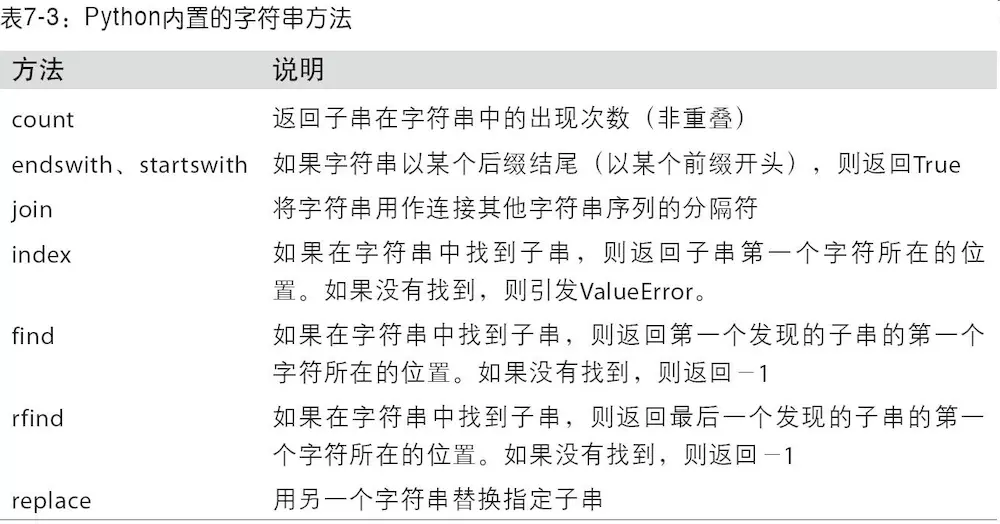

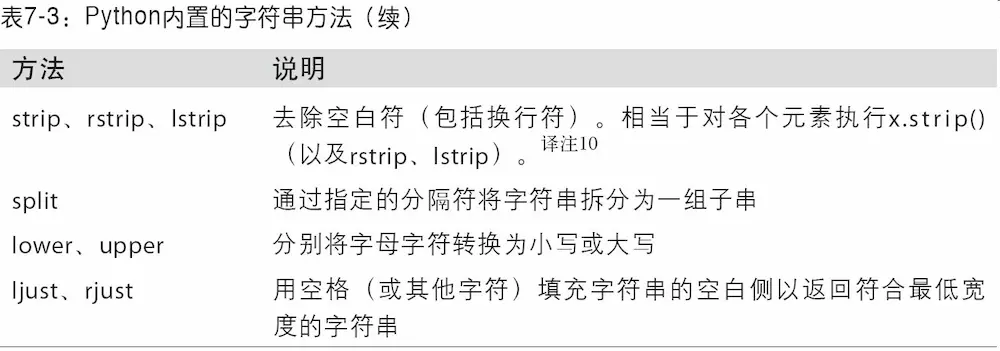

### 正则表达式
拆分：split，匹配：match、search和findall，替代：sub；  
re.compile自己编译regex以得到一个可重用的regex对象

正则表达式提供了一种灵活的在文本中查找或匹配（通常更为复杂）字符串模式的方式。正则表达式，常称作regex，是根据正则表达式语言编写的字符串。Python内置的re模块负责对字符串应用正则表达式。我将通过一些例子说明其使用方法。

>正则表达式的编写技巧可以自成一章，超出了本书的范围。从网上和其它书可以找到许多非常不错的教程和参考资料。

re模块主要有三个主题：模式匹配、替代、拆分。当然，这三部分主题是相关联的。正则表达式描述的是一种在文本中定位的模式，可以用于多种任务。在下面这个例子中，**假设想将含有多种空白字符（制表符、空格、换行符）的字符串拆分开。描述一个或多个空白字符的正则表达式是$\s+$**

In [117]:
import re

In [118]:
text = 'foo     bar\t baz   \tquz'

In [119]:
re.split('\s+', text)

['foo', 'bar', 'baz', 'quz']

调用$re.split('\s+',text)$时，正则表达式会先被编译，然后再在text上调用其split方法。你可以用re.compile自己编译regex以得到一个可重用的regex对象：

In [120]:
regex = re.compile('\s+')
regex.split(text)

['foo', 'bar', 'baz', 'quz']

如果只希望得到匹配regex的所有模式，则可以使用findall方法：

In [121]:
regex.findall(text)

['     ', '\t ', '   \t']

为了在正则表达式中避免转义符（\）的影响，可以使用原始字符串字面量如r'C:\x'（也可以编写其等价式'C:\x'）。

如果需要哦将相同的表达式应用到多个字符串上，推荐使用re.compile创建一个正则表达式对象，这样做有利于节约CPU周期。

match和search与findall相关性大。findall返回的是字符串中所有的匹配项，而search返回的仅仅是第一个匹配项。match更为严格，它只在字符串的起始位置进行匹配。来看一个小例子，假设我们有一段文本以及一条能够识别大部分电子邮件地址的正则表达式：

In [122]:
text = '''Dave dave@google.com
Steve steve@google.com
Rob rob@google.com
Ryan ryan@yahoo.com
'''

In [123]:
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'
#re.IGNORECASE是正则表达式不区分大小写
regex = re.compile(pattern, flags=re.IGNORECASE)

在文本上使用findall会生成一个电子邮件地址的列表：

In [124]:
regex.findall(text)

['dave@google.com', 'steve@google.com', 'rob@google.com', 'ryan@yahoo.com']

search返回的是文本中第一个匹配到的电子邮件索引位置。对于前面提到的正则表达式，匹配对象只能告诉我们模式在字符串中起始和结束的位置：

In [128]:
m = regex.search(text)
m

<re.Match object; span=(5, 20), match='dave@google.com'>

In [126]:
text[m.start():m.end()]

'dave@google.com'

regex.match只在模式出现与字符串起始位置时进行匹配，如果没有匹配到，返回None：

In [129]:
print(regex.match(text))

None


sub方法可以将匹配到的模式替换为指定字符串，并返回所得到的新字符串：

In [131]:
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



假设不仅想要找出电子邮件地址，还想将各个地址分成3个部分：用户名、域名以及域后缀。要实现这一点，只需将待分段的模式的各部分用圆括号包起来即可：

In [132]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z0-9]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

由这个修改后的正则表达式产生的匹配对象，可以通过其groups方法返回一个由模式各段组成的元组：

In [133]:
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

当模式可以分组时，findall返回是包含元组的列表：

In [134]:
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'google', 'com'),
 ('rob', 'google', 'com'),
 ('ryan', 'yahoo', 'com')]

sub还能通过诸如\1、\2之类的特殊符号访问各匹配项中的分组。符号\1对应第一个匹配的组，\2对应第二个匹配的组，以此类推：

In [135]:
print(regex.sub(r'Usersname: \1, Domain: \2, Suffix: \3', text))

Dave Usersname: dave, Domain: google, Suffix: com
Steve Usersname: steve, Domain: google, Suffix: com
Rob Usersname: rob, Domain: google, Suffix: com
Ryan Usersname: ryan, Domain: yahoo, Suffix: com



Python中关于正则表达式还有更多的内容，但是大部分都超出了本书的范围。下表提供了一个简要的概述：

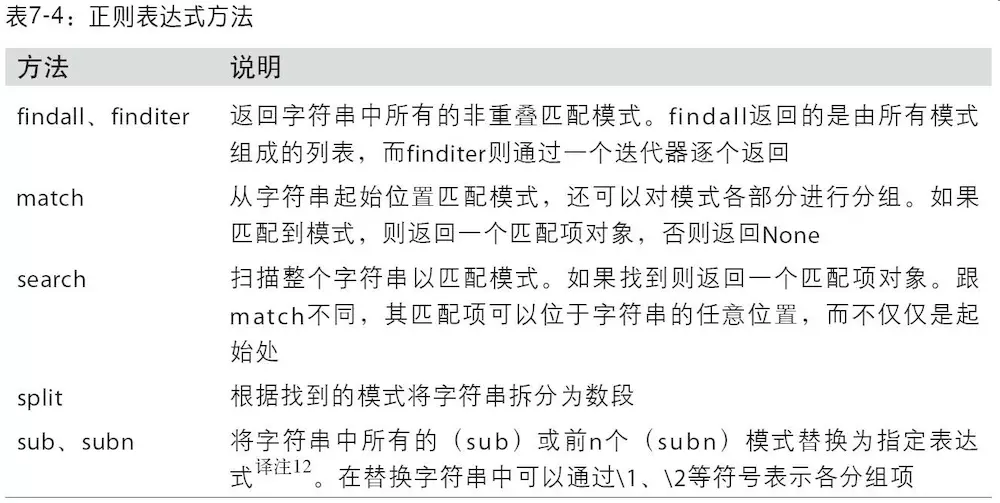

>python正则表达式<http://www.runoob.com/python3/python3-reg-expressions.html>

### pandas中的向量化字符串函数

清理待分析的散乱数据时，常常需要做一些字符串规整化工作。更为复杂的情况是，含有字符串的列有时还含有缺失数据：

In [136]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com', 'Rob': 'rob@gmail.com', 'Wes': np.nan }
data = pd.Series(data)
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [137]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

通过data.map，所有字符串和正则表达式方法都能被应用于（传入lambda表达式或其他函数）各个值，但是如果存在NA（null）就会报错。为了解决这个问题，Series有一些能够跳过NA值的面向数组方法，进行字符串操作。**通过Series的str属性即可访问这些方法。例如，我们可以通过str.contains检查各个电子邮件地址是否含有"gmail"：**

In [138]:
data.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

正则表达式也可以结合任意的re模块选项使用，例如IGNORECASE:

In [139]:
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z0-9]{2,4})'

In [140]:
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Steve    [(steve, gmail, com)]
Rob        [(rob, gmail, com)]
Wes                        NaN
dtype: object

In [141]:
matches = data.str.match(pattern, flags=re.IGNORECASE)
matches

Dave     True
Steve    True
Rob      True
Wes       NaN
dtype: object

有两个办法可以实现矢量化的元素获取操作：要么使用str.get，要么在str属性内使用索引：

要访问嵌入式列表中的元素，我们可以将索引传递给这些函数中的任意一个：

In [143]:
data.str.get(3)

Dave       e
Steve      v
Rob        @
Wes      NaN
dtype: object

In [144]:
data.str[:5]

Dave     dave@
Steve    steve
Rob      rob@g
Wes        NaN
dtype: object

下表有更多pandas字符串方法：
+ 第二行打印错误，count改为contains

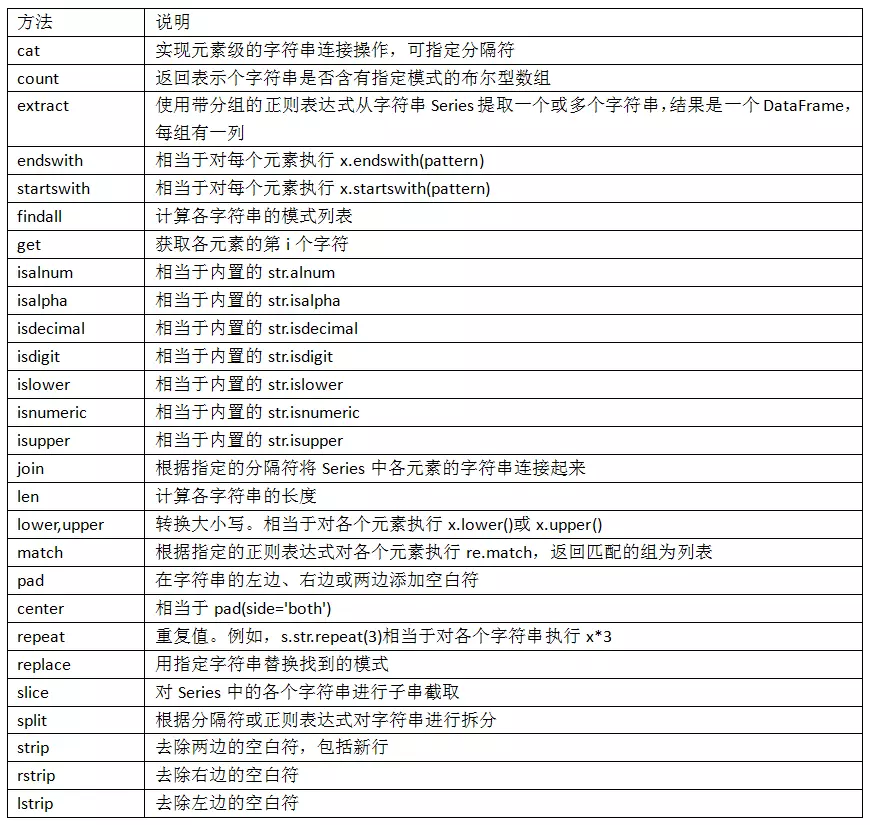